# Part 2 : Check for Reponse Leakage 

### Organization of the Notebook

Part 1: Load Packages 

Part 2: Read Data 

Part 3: Process Data

Part 4: Check `Response Leakage`

Use `KL Divergence` or `Relative Entropy Jensen-Shannon Distance` to Measure the Distribution Similarity between Y vs Categorical Features.  

## Part 1: Load Packages

In [1]:
import pandas as pd
import numpy as np
from numpy.random import RandomState
import re

#from scipy.special import rel_entr
#from scipy.special import kl_div
from scipy.spatial.distance import jensenshannon

In [2]:
import matplotlib
import matplotlib.pyplot as plt

In [3]:
from sklearn.metrics import accuracy_score, auc
from sklearn.model_selection import train_test_split

In [4]:
import shap

In [5]:
%matplotlib inline

## Part 2: Read Data

In [6]:
df = pd.read_excel("data_customerSatisfaction.xlsx", engine="openpyxl")

In [7]:
print("Shape of the Dataframe :", df.shape)

Shape of the Dataframe : (129880, 24)


## Part 3: Process Data

In [8]:
print( df.columns.to_list() )

['id', 'SatisfactionType', 'Gender', 'CustomerType', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']


In [9]:
"""Fix Column Names : Remove White Spaces & Slashes"""
oldName = df.columns.to_list()
newName = [re.sub(" ", "_", x.title()) for x in oldName]
colName = {oldName[i]: newName[i] for i in range(len(oldName))} 
df = df.rename(columns=colName)
df = df.rename(columns={"Departure/Arrival_Time_Convenient":"Departure_Arrival_Time_Convenient"})

In [10]:
#print( df.dtypes )

#### Drop Column "id"

Unique integer. It does not have any leverage in the modeling compared to other features.

In [11]:
df = df.drop(["Id"], axis=1)  

#### Replace Age Null Values by Median Age

In [12]:
medianAge = df.loc[df['Age'].isnull()==False, 'Age'].median()
df.loc[df['Age'].isnull()==True, 'Age'] = medianAge

#### Leg Room Service has Catagores like 0,1,2,3,4,5,44,55. Change 44,55 to 0 

In [13]:
"""Fix Leg Room Service"""
df.loc[ df["Leg_Room_Service"] > 5, "Leg_Room_Service"] = 0

#### Replace Food and Drink Null Values by 1

Find the subset of data having "Online Boarding=Null"

Explore the data property on all other categorical columns in this subset

Assign category to "Online Boarding=Null" based on the observed property of the subset 

In [14]:
"""Fix Food and Drink"""
#df[ df["Food and drink"].isnull()==True ]   # DisLoyal but Satisfied
df.loc[ df["Food_And_Drink"].isnull()==True, "Food_And_Drink" ] = 1.0

#### Replace Online Boarding Null Values  by 1

Following the procedure in "Food and Drink"

In [15]:
"""Fix Online Boarding"""
# df[ df["Online boarding"].isnull()==True ] # Loyal and Satisfied
df.loc[ df["Online_Boarding"].isnull()==True, "Online_Boarding" ] = 1.0

#### Maximum Flight Distance is 9999999. Replace it by Column Median

Flight Distance has outliers

Replace outliers by the column mdedian. Median itself is insensitive to outliers in the data.

In [16]:
"""Flight Distance"""
# print( df["Flight Distance"].mean() ) 
# print( df["Flight Distance"].max() )
distList = sorted( df["Flight_Distance"].unique(), reverse= True)
df.loc[ df["Flight_Distance"] > distList[1],  "Flight_Distance"] = df["Flight_Distance"].median()
# print( df["Flight Distance"].mean() ) 
# print( df["Flight Distance"].max() )

#### Replace Baggage Handling Null values by 0

In [17]:
df.loc[ df["Baggage_Handling"].isnull() == True, "Baggage_Handling" ] = 0

#### Departure Delay in Minutes and Arrival Delay in Minutes are Strongly Correlated (r ~ 0.99) 

In [18]:
"""Drop Arrival Delay in Minutes instead of Departure Delay in Minutes"""
df = df.drop(["Arrival_Delay_In_Minutes"], axis=1)  

#### Make the Dataframe with Appropriate Data Types 

In [19]:
df_feature = df.dtypes.to_frame().reset_index().rename(columns={"index": "Feature", 0: 'FeatureType'})
theObjects = df_feature[ df_feature['FeatureType'] == 'object']
df_object  = df[ theObjects['Feature'] ].copy() 

Feature with Float Data Type

In [20]:
df_float = df[['Age','Flight_Distance','Departure_Delay_In_Minutes']].copy()
df_float = df_float.astype('float64')
nFloat = df_float.shape[1]

Feature with Interger Data Type

In [21]:
object_float_list = df_object.columns.to_list() + df_float.columns.to_list() 
colList = set( df.columns.to_list() )
ofList  = set( object_float_list )
colList.difference_update( ofList )
df_int = df[ list(colList) ].copy()
df_str = df_int.astype('str')

Convert Categorical to Integer Type 

0 = "satisfied"
1 = "neutral or dissatisfied"

In [22]:
df_object['Y'] = df_object.apply(lambda row: 0 if row.Satisfactiontype=="satisfied" else 1, axis=1)

In [23]:
"""Dropping Satisfactiontype. It is replaced by feature Y"""
df_object = df_object.drop(['Satisfactiontype'], axis=1)

Concate the Splitted Parts Back

In [24]:
"""Final Dataframe"""
df = pd.concat([df_object, df_str, df_float], axis=1)
df = df.sample(frac=1.0, replace=False, random_state=1)
print(f'Shape of the final dataframe : {df.shape}')

Shape of the final dataframe : (129880, 22)


## Part 4:  Check for Response Leakage 

Test Objective: if KL Divergence == 0 or JensenShannon == 0 then "Leakage" else "No Leakage"

scipy.special.rel_entr()

In [25]:
# colName = df.columns[ np.where( df.dtypes != np.float ) ]

# y_prb = df.groupby('Y').size().to_list()
# y_prb = [k/df.shape[0] for k in y_prb]

# print("Printing KL Divergence between Y and all Features ...") 
# for col in [i for i in colName if i != 'Y']:
#     col_prb = df.groupby(col).size().to_list()
#     col_prb = [j/df.shape[0] for j in col_prb]
    
#     len_diff = len(col_prb) - len(y_prb)
#     if len_diff > 0:
#         y_prb = y_prb + [0.0]*(len_diff)
#         p_q = rel_entr(y_prb, col_prb)
#         q_p = rel_entr(col_prb, y_prb)
#         kv1 = round(sum(p_q),4)
#         kv2 = round(sum(q_p),4)      
#         print(f'Y vs {col} : {[kv1,kv2]}')
#     else:
#         p_q = rel_entr(y_prb, col_prb)
#         q_p = rel_entr(col_prb, y_prb)
#         kv1 = round(sum(p_q),4)
#         kv2 = round(sum(q_p),4)      
#         print(f'Y vs {col} : {[kv1,kv2]}')

In [26]:
colName = df.columns[ np.where( df.dtypes != float ) ]

y_prb = df.groupby('Y').size().to_list()
y_prb = [k/df.shape[0] for k in y_prb]

res = {}
print("Printing Jenseen-Shannon Distance between Y and all Features ...") 
for col in [i for i in colName if i != 'Y']:
    col_prb = df.groupby(col).size().to_list()
    col_prb = [j/df.shape[0] for j in col_prb]
    
    len_diff = len(col_prb) - len(y_prb)
    if len_diff > 0:
        y_prb = y_prb + [0.0]*(len_diff)
        
        js_pq = jensenshannon(y_prb, col_prb, base=2)
        print(f'Y vs {col} : {round(js_pq,4)}')
        
        res[col] = js_pq  
        
    else:
        js_pq = jensenshannon(y_prb, col_prb, base=2)
        print(f'Y vs {col} : { round(js_pq,4)}')
        
        res[col] = js_pq

Printing Jenseen-Shannon Distance between Y and all Features ...
Y vs Gender : 0.0621
Y vs Customertype : 0.3417
Y vs Type_Of_Travel : 0.2206
Y vs Class : 0.2046
Y vs Leg_Room_Service : 0.8828
Y vs Inflight_Wifi_Service : 0.7941
Y vs Online_Boarding : 0.852
Y vs Baggage_Handling : 0.9151
Y vs Gate_Location : 0.8449
Y vs Food_And_Drink : 0.8707
Y vs Checkin_Service : 0.875
Y vs Inflight_Entertainment : 0.8769
Y vs Inflight_Service : 0.9184
Y vs On-Board_Service : 0.8821
Y vs Ease_Of_Online_Booking : 0.7805
Y vs Cleanliness : 0.8712
Y vs Seat_Comfort : 0.8805
Y vs Departure_Arrival_Time_Convenient : 0.7856


## Conclusion

The JS Distance Measure is > 0 for all features. Therefore, the chance for leakage is improbable 

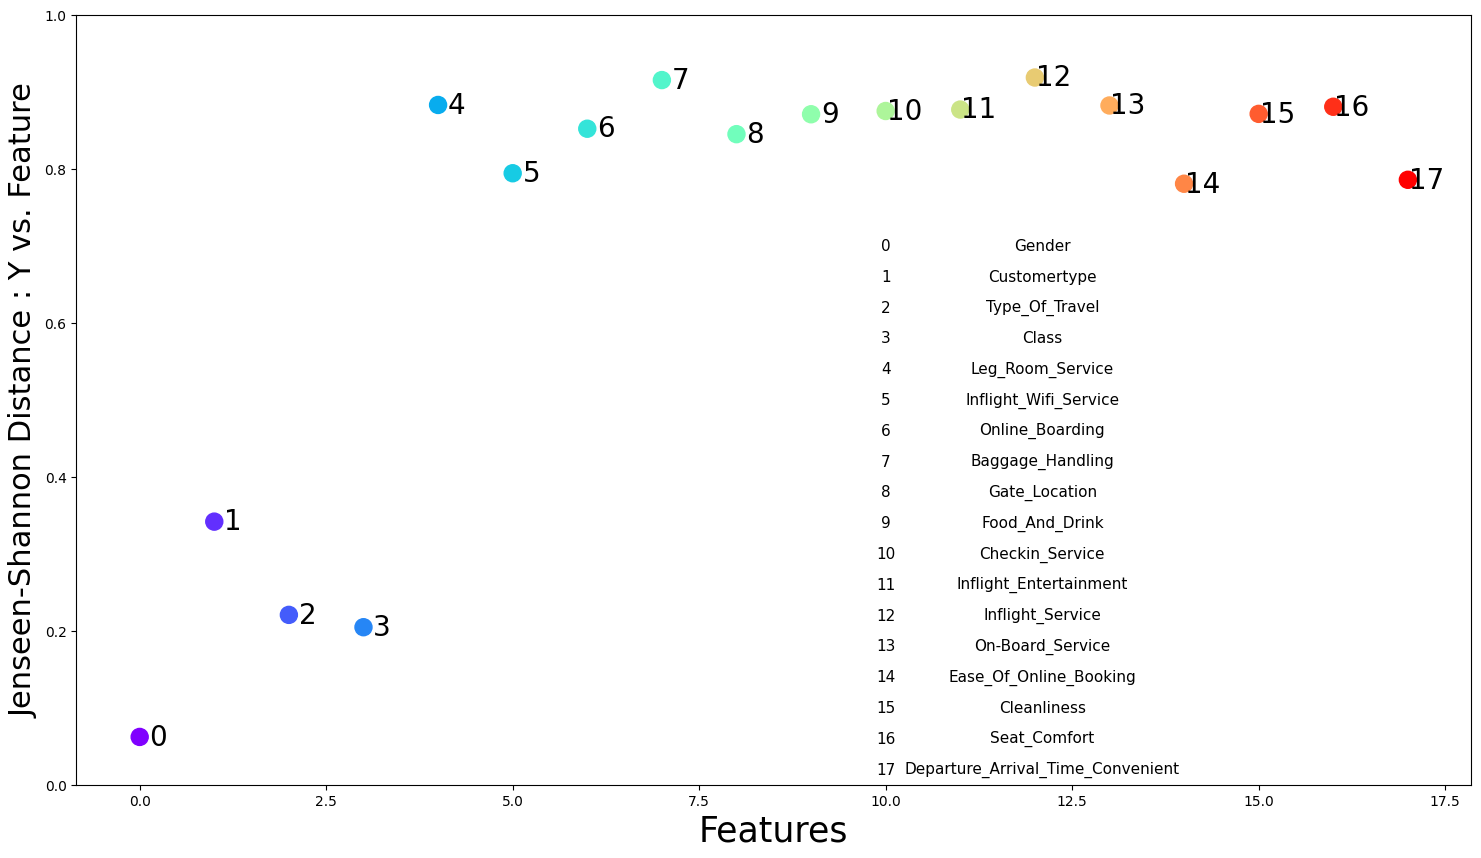

In [27]:
fig = plt.figure( figsize=(18,10) )

x = np.arange( len(res) ) 
col = list(res.keys())
val = list(res.values())

plt.scatter(x, val, s=150, c=np.arange(len(x)), cmap='rainbow')
plt.ylim(0,1)
plt.xlabel('Features', fontsize=25)
plt.ylabel('Jenseen-Shannon Distance : Y vs. Feature', fontsize=22)

for i in range(len(x)):
    plt.text( x[i]+0.25, val[i], str(i), va='center', ha='center', fontsize=20 )  

for i in range(len(x)):
    plt.text( 10, 0.7- 0.04*i, str(i), va='center', ha='center', fontsize=11 )
    
for i in range(len(x)):
    plt.text(12.1, 0.7- 0.04*i, col[i], va='center', ha='center', fontsize=11)